In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 5000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [10,10,8,5,5,5]
cov = np.identity(6)
x_outliers =  pd.DataFrame(np.random.multivariate_normal(mean, cov, 200), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
features = ['f'+str(i) for i in range(1,7)]

In [9]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [10]:
X['pred_AD_score'] = if_model.decision_function(X[features])
X['pred_AD_score'] = -1*X['pred_AD_score']
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5195,10.295784,8.591959,8.110361,4.095833,5.165519,5.644314,1,0.098062
5196,10.096566,11.177026,8.928960,5.005160,4.306513,4.656614,1,0.138123
5197,10.842735,9.120857,7.839060,4.825114,6.047388,4.879606,1,0.097353
5198,9.354751,11.196285,8.869052,4.686461,4.980977,4.454302,1,0.134540
5199,9.542506,9.162028,6.552660,6.922619,3.209259,5.002852,1,0.118421


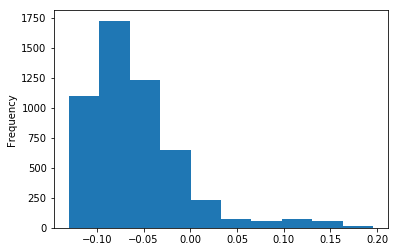

In [11]:
X['pred_AD_score'].plot(kind='hist')

In [12]:
bottom_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
top_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [13]:
top_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
bottom_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [14]:
top_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5107,10.483313,11.190029,9.293386,2.510120,3.375233,5.096444,1,0.195653
5040,10.991195,11.298063,9.618443,3.590652,4.177959,4.597849,1,0.188235
5128,8.414628,11.408258,9.239197,8.087941,4.705241,4.295226,1,0.181947
5030,11.185334,11.120662,6.951416,6.930147,5.349564,3.298548,1,0.180318
5025,12.570198,9.919329,10.162863,3.542267,5.294823,4.670656,1,0.180195
5071,10.874402,11.117589,8.837166,7.089692,5.002359,5.189993,1,0.176483
5123,11.219536,11.433133,8.029556,3.771907,3.673373,3.862708,1,0.176191
5144,11.422012,10.345415,8.287972,3.823682,3.135522,3.598640,1,0.172253
5035,11.142167,10.246179,7.448691,7.025044,3.049217,3.684800,1,0.171641
5012,8.509132,10.787843,10.010746,7.671164,5.189976,5.115395,1,0.171520


In [15]:
k = 20
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return -1*df

acme_ifo = ACME(model = if_model, target = 'AD_score', K=k, task='ad', score_function=score_function, features=features)
acme_ifo = acme_ifo.fit(X[features], robust = True)

In [16]:
#acme_local = acme_ifo.fit_local(X[features], top_anomalies.index[-1])
acme_local = acme_ifo.fit_local(X[features], bottom_anomalies.index[-1])
#acme_local = acme_ifo.fit_local(X[features], top_normal.index[-1])
#acme_local = acme_ifo.fit_local(X[features], bottom_normal.index[-1])

In [17]:
acme_local.summary_table(local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile
feature,,,,,,,
f1,0.091297,0.091297,0.010295,0.584607,0.000000,numeric,0.592115
f1,0.036023,0.036023,0.010295,3.387287,0.055556,numeric,0.592115
f1,0.035298,0.035298,0.010295,3.776607,0.111111,numeric,0.592115
f1,0.030749,0.030749,0.010295,4.057384,0.166667,numeric,0.592115
f1,0.018766,0.018766,0.010295,4.263430,0.222222,numeric,0.592115
...,...,...,...,...,...,...,...
f6,0.021181,0.021181,0.010295,5.752986,0.777778,numeric,0.529808
f6,0.028699,0.028699,0.010295,5.951245,0.833333,numeric,0.529808
f6,0.035175,0.035175,0.010295,6.182646,0.888889,numeric,0.529808


In [18]:
acme_local.feature_importance()

,importance
feature,
f3,0.031137
f1,0.025328
f4,0.023839
f6,0.021856
f2,0.016853
f5,0.015309


In [19]:
acme_local.feature_importance(local=True, weights = {'ratio':0.1,'delta':0.1,'change':0.3,'distance':0.5})

,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f4,0.675603,0.090139,1.0,0.044594,0.039536,-0.050603,0.010295,0.854277
f5,0.624796,0.074524,1.0,0.049594,0.038257,-0.036267,0.010295,0.845135
f3,0.300322,0.100021,1.0,0.068590,0.080278,-0.019743,0.010295,0.805739
f1,0.020781,0.112966,0.0,1.000000,0.120914,0.007947,0.010295,0.013375
f2,0.000000,0.105482,0.0,1.000000,0.115777,0.010295,0.010295,0.010548
f6,0.019600,0.085778,0.0,1.000000,0.094392,0.008614,0.010295,0.010538


In [20]:
acme_local.feature_importance(local=True, weights = {'ratio':0.4,'delta':0.1,'change':0.3,'distance':0.2})

,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f4,0.675603,0.090139,1.0,0.044594,0.039536,-0.050603,0.010295,0.770336
f5,0.624796,0.074524,1.0,0.049594,0.038257,-0.036267,0.010295,0.747452
f3,0.300322,0.100021,1.0,0.068590,0.080278,-0.019743,0.010295,0.616413
f1,0.020781,0.112966,0.0,1.000000,0.120914,0.007947,0.010295,0.019609
f6,0.019600,0.085778,0.0,1.000000,0.094392,0.008614,0.010295,0.016418
f2,0.000000,0.105482,0.0,1.000000,0.115777,0.010295,0.010295,0.010548


In [21]:
acme_local.feature_exploration('f1',local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile,size,direction
feature,,,,,,,,,
f1,0.081002,0.091297,0.010295,0.584607,0.000000,numeric,0.592115,0.1,anomalies
f1,0.025728,0.036023,0.010295,3.387287,0.055556,numeric,0.592115,0.1,anomalies
f1,0.025003,0.035298,0.010295,3.776607,0.111111,numeric,0.592115,0.1,anomalies
f1,0.020454,0.030749,0.010295,4.057384,0.166667,numeric,0.592115,0.1,anomalies
f1,0.008471,0.018766,0.010295,4.263430,0.222222,numeric,0.592115,0.1,anomalies
f1,0.006121,0.016417,0.010295,4.453569,0.277778,numeric,0.592115,0.1,anomalies
f1,0.002218,0.012513,0.010295,4.617972,0.333333,numeric,0.592115,0.1,anomalies
f1,0.003375,0.013670,0.010295,4.763987,0.388889,numeric,0.592115,0.1,anomalies
f1,-0.002348,0.007947,0.010295,4.901622,0.444444,numeric,0.592115,0.1,anomalies


In [22]:
acme_local.feature_exploration('f2',local=True,plot=True)

In [23]:
acme_local.baseline_values()

,f1,f2,f3,f4,f5,f6
0,5.184922,5.202211,5.118997,5.018742,4.997004,4.992526


In [24]:
acme_local.summary_plot(local=True)

In [25]:
acme_local.summary_table(local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile
feature,,,,,,,
f1,0.091297,0.091297,0.010295,0.584607,0.000000,numeric,0.592115
f1,0.036023,0.036023,0.010295,3.387287,0.055556,numeric,0.592115
f1,0.035298,0.035298,0.010295,3.776607,0.111111,numeric,0.592115
f1,0.030749,0.030749,0.010295,4.057384,0.166667,numeric,0.592115
f1,0.018766,0.018766,0.010295,4.263430,0.222222,numeric,0.592115
...,...,...,...,...,...,...,...
f6,0.021181,0.021181,0.010295,5.752986,0.777778,numeric,0.529808
f6,0.028699,0.028699,0.010295,5.951245,0.833333,numeric,0.529808
f6,0.035175,0.035175,0.010295,6.182646,0.888889,numeric,0.529808
